Simulation data saved to: C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_10.csv


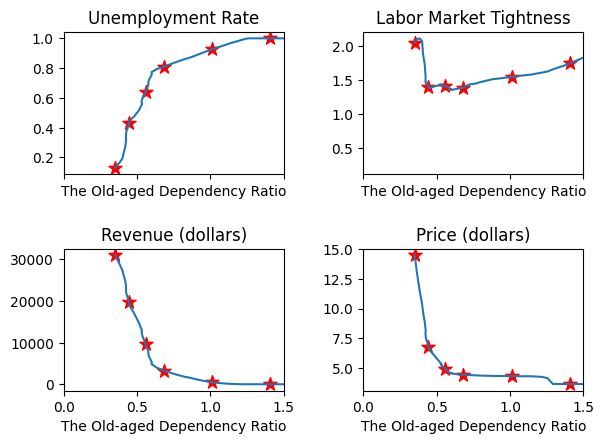

In [11]:
#num_firms = 10
import random
import math
import sympy as sp
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

#initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05
initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.645, 0.147, 0.0594

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_workforce * initial_aging_rate)

#job_finding_rate, job_separation_rate = 0.2, 0.2
job_finding_rate, job_separation_rate = 0.433, 0.024

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.9, 0.1, 0.01

# Initialize population
# not0_young_coh means persons with age from 1 to 14 inclusive
# young_coh means persons with age from 0 to 14 inclusive
newborn_coh, senior_coh, not0_young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed

    def update_age(self):
        self.age += 1

    def is_newborn(self):
        return self.age == 0

    def is_young(self):
        return self.age < 15

    def is_workforce(self):
        return 14 < self.age < retirement_age

    def is_senior(self):
        return self.age >= retirement_age

    def is_unemployed(self):
        return not self.employed

    def is_employed(self):
        return self.employed

# initialize population-related variables

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(1, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else not0_young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_coh = list(itertools.chain(newborn_coh, not0_young_coh))
pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))

cohorts = [[len(young_coh)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)

        if hire_or_fire_decision:  # Hiring decision
            #if update_job == 1:
            self.job_vacancy += num_new_vacancies
            #print(self.job_vacancy)
            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), num_new_vacancies)
            #self.job_vacancy -= num_hired

            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            self.job_vacancy -= int(0.01*self.job_vacancy)
            return 0, num_fired, self.job_vacancy


    def update_prices(self, total_demand):

        supply = len(emp_coh)
        #self.price = self.vacancy_cost + math.sqrt(total_demand) / len(firms) - supply / 2500
        self.price = self.vacancy_cost + total_demand / len(firms) - supply / 2500
        prof = max((self.price - self.vacancy_cost) * total_demand/len(firms),0)
        return self.price, prof

# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

def tt_demand(N, U, A, p_bar):
    B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
    S = N-U
    niu = min(1, S/B)

    return (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
    (N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
    U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/p_bar

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A

    def calculate_profit(self):
        p_bar0 = sum(firm.price for firm in self.firms)/len(firms)
        p_bar = sum(firm.update_prices(tt_demand(self.N, self.U, self.A, p_bar0))[0] for firm in self.firms)/len(self.firms)

        tot_demand = tt_demand(self.N, self.U, self.A, p_bar)
        tot_profit = sum(firm.update_prices(tot_demand)[1] for firm in self.firms)

        return tot_demand, tot_profit

'''
class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

'''
old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
random.seed(3)
num_firms = 10
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]

# Initialize the LaborMarket with firms and initial_workforce
#labor_market = LaborMarket(firms)  # Pass initial_workforce here
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
#initial_vacancy = labor_market.new_workstatus()[2]
initial_vacancy = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
theta = [initial_vacancy / len(unemp_coh)]
initial_average_price = sum(firm.price for firm in firms) / len(firms)
prices_in_goods_market = [initial_average_price]

goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
tot_dem = [goods_market.calculate_profit()[0]]
job_vacancies = [initial_vacancy]

num_unemp = [len(unemp_coh)]

firm_profits = [goods_market.calculate_profit()[1]]

simulation_years = 300
random.seed(3)

for year in range(1, simulation_years):
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person

    for person in young_coh:
        person.update_age()
        if person.age == 1:
            updated_young_coh.append(person)
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)
# unit test
# manual test
# assert
    for person in workforce_coh:
        person.update_age()
        if person.is_workforce():
            updated_workforce_coh.append(person)
            if person.is_unemployed():
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)

    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)

    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(updated_senior_coh) * death_rate)
    random.shuffle(updated_senior_coh)
    removed_senior_coh = updated_senior_coh[:death]
    senior_coh = updated_senior_coh[death:]

    # Update the newborn
    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_young_coh.append(person)
        updated_newborn_coh.append(person)

    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = updated_workforce_coh
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh

    pop = list(itertools.chain(newborn_coh, young_coh, workforce_coh, senior_coh))
    #print('workforce proportion:', len(workforce_coh)/len(pop))
    #print('aged dependency ratio:', len(senior_coh)/len(workforce_coh))

    # firms updated
    """"for firm in firms:
      print(firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[0],firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[1], \
            firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[2])
    """

    # Goods market dynamics
    goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
    total_demand_this_year = goods_market.calculate_profit()[0]

    #print('total_demand:', total_demand_this_year)
    tot_dem.append(total_demand_this_year)

    # Calculate new employment and unemployment rates for this year
    new_unemployment_rate = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    num_unemp.append(len(unemp_coh))
    unemployment_rates.append(new_unemployment_rate)

    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = len(pop)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate firm-related variables
    # num_job_vacancies = labor_market.new_workstatus()[2]
    num_job_vacancies = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
    job_vacancies.append(num_job_vacancies)
    #job_vacancies.append(num_job_vacancies)

    tot_price = 0
    for firm in firms:
        tot_price += firm.update_prices(total_demand_this_year)[0]

    #total_firm_profits = goods_market.calculate_profit()[1]
    total_firm_profits = sum(firm.update_prices(len(emp_coh))[1] for firm in firms)

    #supply_this_year = labor_market.new_workstatus()[0]
    supply_this_year = len(emp_coh)
    #print(supply_this_year, total_demand_this_year)
    #print('\n')

    #print('average price:', tot_price/len(firms))
    #print('total_firm_profits:', total_firm_profits)
    #print('\n')
    firm_profits.append(total_firm_profits)

    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)

    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    #total_prices_in_goods_market = sum(firm.update_prices(total_demand_this_year)[0] for firm in firms) / len(firms)
    total_prices_in_goods_market = tot_price
    prices_in_goods_market.append(total_prices_in_goods_market)

#store generated data to hard drive
data_10 = [unemployment_rates, theta, firm_profits,prices_in_goods_market]

import csv

file_path = r"C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_10.csv"

# Transpose the data (swap rows and columns)
transposed_data = zip(*data_10)

# Open the file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional)
    csv_writer.writerow(['Unemployment Rates', 'Theta', 'Firm Profits', 'Prices in Goods Market'])

    # Write the data to the CSV file
    csv_writer.writerows(transposed_data)
print("Simulation data saved to:", file_path)

#print(tot_dem)
# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
index= 4
axs[0, 0].plot(old_aged_dependency_ratios[index:], unemployment_rates[index:], label="Unemployment Rate")
axs[0, 0].scatter(old_aged_dependency_ratios[index::10], unemployment_rates[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 0].set_title('Unemployment Rate')

axs[0, 1].plot(old_aged_dependency_ratios[index:], theta[index:], label="Labor Market Tightness")
axs[0, 1].scatter(old_aged_dependency_ratios[index::10], theta[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 1].set_title('Labor Market Tightness')

axs[1, 0].plot(old_aged_dependency_ratios[index:], firm_profits[index:], label="Revenue (dollars)")
axs[1, 0].scatter(old_aged_dependency_ratios[index::10], firm_profits[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 0].set_title('Revenue (dollars)')
#axs[1, 0].set_ylim(1.1, 1.3)

axs[1, 1].plot(old_aged_dependency_ratios[index:], prices_in_goods_market[index:], label="Prices in Goods Market")
axs[1, 1].scatter(old_aged_dependency_ratios[index::10], prices_in_goods_market[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 1].set_title('Price (dollars)')
#axs[1, 1].set_ylim(0, 0.38)

axs[0, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[0, 1].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 1].set_xlabel('The Old-aged Dependency Ratio')

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
#fig.savefig(r'C:\Users\enmao\OneDrive - Carleton University\mas thesis\plot0926.png')
plt.show()


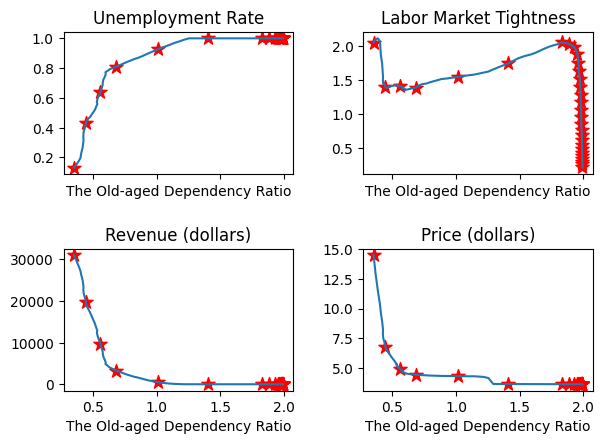

In [12]:
# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
index= 4
# Unemployment Rate plot
axs[0, 0].plot(old_aged_dependency_ratios[index:], unemployment_rates[index:], label="Unemployment Rate")
axs[0, 0].scatter(old_aged_dependency_ratios[index::10], unemployment_rates[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 0].set_title('Unemployment Rate')

# Labor Market Tightness plot
axs[0, 1].plot(old_aged_dependency_ratios[index:], theta[index:], label="Labor Market Tightness")
axs[0, 1].scatter(old_aged_dependency_ratios[index::10], theta[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 1].set_title('Labor Market Tightness')

# Revenue (Firm Profits) plot
axs[1, 0].plot(old_aged_dependency_ratios[index:], firm_profits[index:], label="Revenue (dollars)")
axs[1, 0].scatter(old_aged_dependency_ratios[index::10], firm_profits[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 0].set_title('Revenue (dollars)')

# Prices in Goods Market plot
axs[1, 1].plot(old_aged_dependency_ratios[index:], prices_in_goods_market[index:], label="Prices in Goods Market")
axs[1, 1].scatter(old_aged_dependency_ratios[index::10], prices_in_goods_market[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 1].set_title('Price (dollars)')

# Set labels for all subplots
axs[0, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[0, 1].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 1].set_xlabel('The Old-aged Dependency Ratio')

#plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
plt.show()


Simulation data saved to: C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_50_2.csv


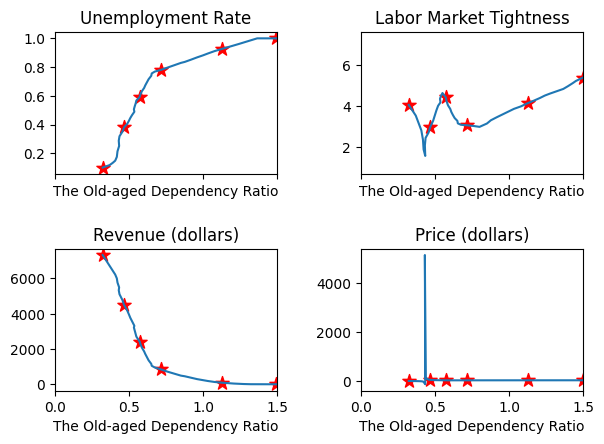

In [2]:
#num_firms = 50
import random
import math
import sympy as sp
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)

#job_finding_rate, job_separation_rate = 0.2, 0.2
job_finding_rate, job_separation_rate = 0.433, 0.024

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.9, 0.1, 0.01

# Initialize population
# not0_young_coh means persons with age from 1 to 14 inclusive
# young_coh means persons with age from 0 to 14 inclusive
newborn_coh, senior_coh, not0_young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed

    def update_age(self):
        self.age += 1

    def is_newborn(self):
        return self.age == 0

    def is_young(self):
        return self.age < 15

    def is_workforce(self):
        return 14 < self.age < retirement_age

    def is_senior(self):
        return self.age >= retirement_age

    def is_unemployed(self):
        return not self.employed

    def is_employed(self):
        return self.employed

# initialize population-related variables

#random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(1, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else not0_young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_coh = list(itertools.chain(newborn_coh, not0_young_coh))
pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))

cohorts = [[len(young_coh)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)

        if hire_or_fire_decision:  # Hiring decision
            #if update_job == 1:
            self.job_vacancy += num_new_vacancies
            #print(self.job_vacancy)
            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), num_new_vacancies)
            #self.job_vacancy -= num_hired

            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            self.job_vacancy -= int(0.01*self.job_vacancy)
            return 0, num_fired, self.job_vacancy


    def update_prices(self, total_demand):

        supply = len(emp_coh)
        #self.price = self.vacancy_cost + math.sqrt(total_demand) / len(firms) - supply / 2500
        self.price = self.vacancy_cost + total_demand / len(firms) - supply / 2500
        prof = max((self.price - self.vacancy_cost) * total_demand/len(firms),0)
        return self.price, prof

# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

def tt_demand(N, U, A, p_bar):
    B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
    S = N-U
    niu = min(1, S/B)

    return (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
    (N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
    U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/p_bar

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A

    def calculate_profit(self):
        p_bar0 = sum(firm.price for firm in self.firms)/len(firms)
        p_bar = sum(firm.update_prices(tt_demand(self.N, self.U, self.A, p_bar0))[0] for firm in self.firms)/len(self.firms)

        tot_demand = tt_demand(self.N, self.U, self.A, p_bar)
        tot_profit = sum(firm.update_prices(tot_demand)[1] for firm in self.firms)

        return tot_demand, tot_profit

'''
class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

'''
old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
#random.seed(3)
num_firms = 50
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]

# Initialize the LaborMarket with firms and initial_workforce
#labor_market = LaborMarket(firms)  # Pass initial_workforce here
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
#initial_vacancy = labor_market.new_workstatus()[2]
initial_vacancy = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
theta = [initial_vacancy / len(unemp_coh)]
initial_average_price = sum(firm.price for firm in firms) / len(firms)
prices_in_goods_market = [initial_average_price]

goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
tot_dem = [goods_market.calculate_profit()[0]]
job_vacancies = [initial_vacancy]

num_unemp = [len(unemp_coh)]

firm_profits = [goods_market.calculate_profit()[1]]

simulation_years = 300
#random.seed(3)

for year in range(1, simulation_years):
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person

    for person in young_coh:
        person.update_age()
        if person.age == 1:
            updated_young_coh.append(person)
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)
# unit test
# manual test
# assert
    for person in workforce_coh:
        person.update_age()
        if person.is_workforce():
            updated_workforce_coh.append(person)
            if person.is_unemployed():
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)

    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)

    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(updated_senior_coh) * death_rate)
    random.shuffle(updated_senior_coh)
    removed_senior_coh = updated_senior_coh[:death]
    senior_coh = updated_senior_coh[death:]

    # Update the newborn
    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_young_coh.append(person)
        updated_newborn_coh.append(person)

    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = updated_workforce_coh
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh

    pop = list(itertools.chain(newborn_coh, young_coh, workforce_coh, senior_coh))
    #print('workforce proportion:', len(workforce_coh)/len(pop))
    #print('aged dependency ratio:', len(senior_coh)/len(workforce_coh))

    # firms updated
    """"for firm in firms:
      print(firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[0],firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[1], \
            firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[2])
    """

    # Goods market dynamics
    goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
    total_demand_this_year = goods_market.calculate_profit()[0]

    #print('total_demand:', total_demand_this_year)
    tot_dem.append(total_demand_this_year)

    # Calculate new employment and unemployment rates for this year
    new_unemployment_rate = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    num_unemp.append(len(unemp_coh))
    unemployment_rates.append(new_unemployment_rate)

    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = len(pop)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate firm-related variables
    # num_job_vacancies = labor_market.new_workstatus()[2]
    num_job_vacancies = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
    job_vacancies.append(num_job_vacancies)
    #job_vacancies.append(num_job_vacancies)

    tot_price = 0
    for firm in firms:
        tot_price += firm.update_prices(total_demand_this_year)[0]

    #total_firm_profits = goods_market.calculate_profit()[1]
    total_firm_profits = sum(firm.update_prices(len(emp_coh))[1] for firm in firms)

    #supply_this_year = labor_market.new_workstatus()[0]
    supply_this_year = len(emp_coh)
    #print(supply_this_year, total_demand_this_year)
    #print('\n')

    #print('average price:', tot_price/len(firms))
    #print('total_firm_profits:', total_firm_profits)
    #print('\n')
    firm_profits.append(total_firm_profits)

    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)

    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    #total_prices_in_goods_market = sum(firm.update_prices(total_demand_this_year)[0] for firm in firms) / len(firms)
    total_prices_in_goods_market = tot_price
    prices_in_goods_market.append(total_prices_in_goods_market)
#print(tot_dem)

#store generated data to hard drive
data_50 = [unemployment_rates, theta, firm_profits,prices_in_goods_market]

import csv

file_path = r"C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_50_2.csv"

# Transpose the data (swap rows and columns)
transposed_data = zip(*data_50)

# Open the file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional)
    csv_writer.writerow(['Unemployment Rates', 'Theta', 'Firm Profits', 'Prices in Goods Market'])

    # Write the data to the CSV file
    csv_writer.writerows(transposed_data)
print("Simulation data saved to:", file_path)

# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
index= 4
axs[0, 0].plot(old_aged_dependency_ratios[index:], unemployment_rates[index:], label="Unemployment Rate")
axs[0, 0].scatter(old_aged_dependency_ratios[index::10], unemployment_rates[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 0].set_title('Unemployment Rate')

axs[0, 1].plot(old_aged_dependency_ratios[index:], theta[index:], label="Labor Market Tightness")
axs[0, 1].scatter(old_aged_dependency_ratios[index::10], theta[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 1].set_title('Labor Market Tightness')

axs[1, 0].plot(old_aged_dependency_ratios[index:], firm_profits[index:], label="Revenue (dollars)")
axs[1, 0].scatter(old_aged_dependency_ratios[index::10], firm_profits[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 0].set_title('Revenue (dollars)')
#axs[1, 0].set_ylim(1.1, 1.3)

axs[1, 1].plot(old_aged_dependency_ratios[index:], prices_in_goods_market[index:], label="Prices in Goods Market")
axs[1, 1].scatter(old_aged_dependency_ratios[index::10], prices_in_goods_market[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 1].set_title('Price (dollars)')
#axs[1, 1].set_ylim(0, 0.38)

axs[0, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[0, 1].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 1].set_xlabel('The Old-aged Dependency Ratio')

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
#fig.savefig(r'C:\Users\enmao\OneDrive - Carleton University\mas thesis\plot0926.png')
plt.show()


Simulation data saved to: C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_100.csv


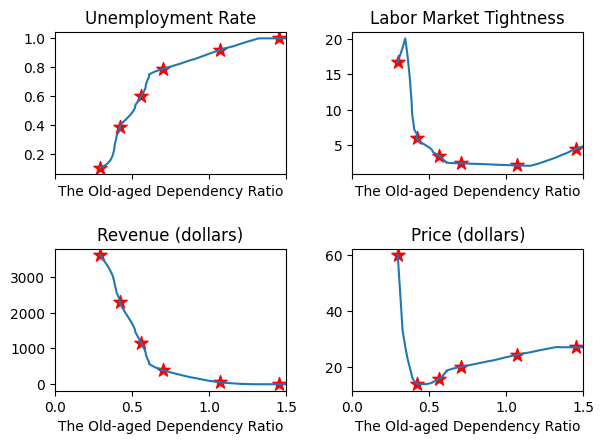

In [29]:
#num_firms = 100
import random
import math
import sympy as sp
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)

#job_finding_rate, job_separation_rate = 0.2, 0.2
job_finding_rate, job_separation_rate = 0.433, 0.024

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.9, 0.1, 0.01

# Initialize population
# not0_young_coh means persons with age from 1 to 14 inclusive
# young_coh means persons with age from 0 to 14 inclusive
newborn_coh, senior_coh, not0_young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed

    def update_age(self):
        self.age += 1

    def is_newborn(self):
        return self.age == 0

    def is_young(self):
        return self.age < 15

    def is_workforce(self):
        return 14 < self.age < retirement_age

    def is_senior(self):
        return self.age >= retirement_age

    def is_unemployed(self):
        return not self.employed

    def is_employed(self):
        return self.employed

# initialize population-related variables

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(1, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else not0_young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_coh = list(itertools.chain(newborn_coh, not0_young_coh))
pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))

cohorts = [[len(young_coh)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)

        if hire_or_fire_decision:  # Hiring decision
            #if update_job == 1:
            self.job_vacancy += num_new_vacancies
            #print(self.job_vacancy)
            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), num_new_vacancies)
            #self.job_vacancy -= num_hired

            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            self.job_vacancy -= int(0.01*self.job_vacancy)
            return 0, num_fired, self.job_vacancy


    def update_prices(self, total_demand):

        supply = len(emp_coh)
        #self.price = self.vacancy_cost + math.sqrt(total_demand) / len(firms) - supply / 2500
        self.price = self.vacancy_cost + total_demand / len(firms) - supply / 2500
        prof = max((self.price - self.vacancy_cost) * total_demand/len(firms),0)
        return self.price, prof

# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

def tt_demand(N, U, A, p_bar):
    B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
    S = N-U
    niu = min(1, S/B)

    return (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
    (N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
    U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/p_bar

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A

    def calculate_profit(self):
        p_bar0 = sum(firm.price for firm in self.firms)/len(firms)
        p_bar = sum(firm.update_prices(tt_demand(self.N, self.U, self.A, p_bar0))[0] for firm in self.firms)/len(self.firms)

        tot_demand = tt_demand(self.N, self.U, self.A, p_bar)
        tot_profit = sum(firm.update_prices(tot_demand)[1] for firm in self.firms)

        return tot_demand, tot_profit

'''
class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

'''
old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
random.seed(3)
num_firms = 100
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]

# Initialize the LaborMarket with firms and initial_workforce
#labor_market = LaborMarket(firms)  # Pass initial_workforce here
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
#initial_vacancy = labor_market.new_workstatus()[2]
initial_vacancy = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
theta = [initial_vacancy / len(unemp_coh)]
initial_average_price = sum(firm.price for firm in firms) / len(firms)
prices_in_goods_market = [initial_average_price]

goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
tot_dem = [goods_market.calculate_profit()[0]]
job_vacancies = [initial_vacancy]

num_unemp = [len(unemp_coh)]

firm_profits = [goods_market.calculate_profit()[1]]

simulation_years = 300
random.seed(3)

for year in range(1, simulation_years):
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person

    for person in young_coh:
        person.update_age()
        if person.age == 1:
            updated_young_coh.append(person)
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)
# unit test
# manual test
# assert
    for person in workforce_coh:
        person.update_age()
        if person.is_workforce():
            updated_workforce_coh.append(person)
            if person.is_unemployed():
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)

    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)

    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(updated_senior_coh) * death_rate)
    random.shuffle(updated_senior_coh)
    removed_senior_coh = updated_senior_coh[:death]
    senior_coh = updated_senior_coh[death:]

    # Update the newborn
    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_young_coh.append(person)
        updated_newborn_coh.append(person)

    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = updated_workforce_coh
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh

    pop = list(itertools.chain(newborn_coh, young_coh, workforce_coh, senior_coh))
    #print('workforce proportion:', len(workforce_coh)/len(pop))
    #print('aged dependency ratio:', len(senior_coh)/len(workforce_coh))

    # firms updated
    """"for firm in firms:
      print(firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[0],firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[1], \
            firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[2])
    """

    # Goods market dynamics
    goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
    total_demand_this_year = goods_market.calculate_profit()[0]

    #print('total_demand:', total_demand_this_year)
    tot_dem.append(total_demand_this_year)

    # Calculate new employment and unemployment rates for this year
    new_unemployment_rate = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    num_unemp.append(len(unemp_coh))
    unemployment_rates.append(new_unemployment_rate)

    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = len(pop)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate firm-related variables
    # num_job_vacancies = labor_market.new_workstatus()[2]
    num_job_vacancies = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
    job_vacancies.append(num_job_vacancies)
    #job_vacancies.append(num_job_vacancies)

    tot_price = 0
    for firm in firms:
        tot_price += firm.update_prices(total_demand_this_year)[0]

    #total_firm_profits = goods_market.calculate_profit()[1]
    total_firm_profits = sum(firm.update_prices(len(emp_coh))[1] for firm in firms)

    #supply_this_year = labor_market.new_workstatus()[0]
    supply_this_year = len(emp_coh)
    #print(supply_this_year, total_demand_this_year)
    #print('\n')

    #print('average price:', tot_price/len(firms))
    #print('total_firm_profits:', total_firm_profits)
    #print('\n')
    firm_profits.append(total_firm_profits)

    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)

    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    #total_prices_in_goods_market = sum(firm.update_prices(total_demand_this_year)[0] for firm in firms) / len(firms)
    total_prices_in_goods_market = tot_price
    prices_in_goods_market.append(total_prices_in_goods_market)
#print(tot_dem)

#store generated data to hard drive
data_100 = [unemployment_rates, theta, firm_profits,prices_in_goods_market]

import csv

file_path = r"C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_100.csv"

# Transpose the data (swap rows and columns)
transposed_data = zip(*data_100)

# Open the file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional)
    csv_writer.writerow(['Unemployment Rates', 'Theta', 'Firm Profits', 'Prices in Goods Market'])

    # Write the data to the CSV file
    csv_writer.writerows(transposed_data)
print("Simulation data saved to:", file_path)

# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
index= 4
axs[0, 0].plot(old_aged_dependency_ratios[index:], unemployment_rates[index:], label="Unemployment Rate")
axs[0, 0].scatter(old_aged_dependency_ratios[index::10], unemployment_rates[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 0].set_title('Unemployment Rate')

axs[0, 1].plot(old_aged_dependency_ratios[index:], theta[index:], label="Labor Market Tightness")
axs[0, 1].scatter(old_aged_dependency_ratios[index::10], theta[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 1].set_title('Labor Market Tightness')

axs[1, 0].plot(old_aged_dependency_ratios[index:], firm_profits[index:], label="Revenue (dollars)")
axs[1, 0].scatter(old_aged_dependency_ratios[index::10], firm_profits[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 0].set_title('Revenue (dollars)')
#axs[1, 0].set_ylim(1.1, 1.3)

axs[1, 1].plot(old_aged_dependency_ratios[index:], prices_in_goods_market[index:], label="Prices in Goods Market")
axs[1, 1].scatter(old_aged_dependency_ratios[index::10], prices_in_goods_market[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 1].set_title('Price (dollars)')
#axs[1, 1].set_ylim(0, 0.38)

axs[0, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[0, 1].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 1].set_xlabel('The Old-aged Dependency Ratio')

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
#fig.savefig(r'C:\Users\enmao\OneDrive - Carleton University\mas thesis\plot0926.png')
plt.show()


Simulation data saved to: C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_200.csv


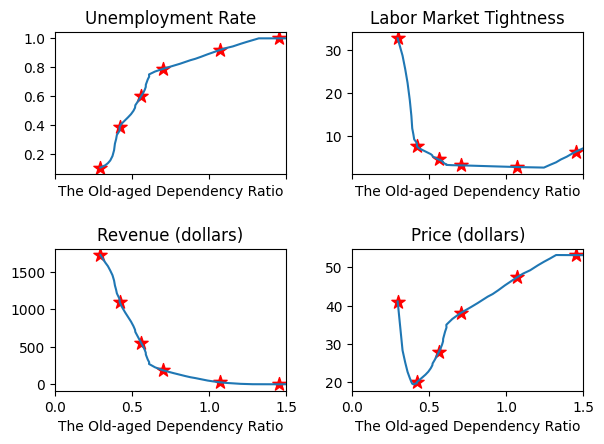

In [30]:
import random
import math
import sympy as sp
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)

#job_finding_rate, job_separation_rate = 0.2, 0.2
job_finding_rate, job_separation_rate = 0.433, 0.024

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.9, 0.1, 0.01

# Initialize population
# not0_young_coh means persons with age from 1 to 14 inclusive
# young_coh means persons with age from 0 to 14 inclusive
newborn_coh, senior_coh, not0_young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed

    def update_age(self):
        self.age += 1

    def is_newborn(self):
        return self.age == 0

    def is_young(self):
        return self.age < 15

    def is_workforce(self):
        return 14 < self.age < retirement_age

    def is_senior(self):
        return self.age >= retirement_age

    def is_unemployed(self):
        return not self.employed

    def is_employed(self):
        return self.employed

# initialize population-related variables

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(1, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else not0_young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_coh = list(itertools.chain(newborn_coh, not0_young_coh))
pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))

cohorts = [[len(young_coh)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)

        if hire_or_fire_decision:  # Hiring decision
            #if update_job == 1:
            self.job_vacancy += num_new_vacancies
            #print(self.job_vacancy)
            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), num_new_vacancies)
            #self.job_vacancy -= num_hired

            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            self.job_vacancy -= int(0.01*self.job_vacancy)
            return 0, num_fired, self.job_vacancy


    def update_prices(self, total_demand):

        supply = len(emp_coh)
        #self.price = self.vacancy_cost + math.sqrt(total_demand) / len(firms) - supply / 2500
        self.price = self.vacancy_cost + total_demand / len(firms) - supply / 2500
        prof = max((self.price - self.vacancy_cost) * total_demand/len(firms),0)
        return self.price, prof

# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

def tt_demand(N, U, A, p_bar):
    B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
    S = N-U
    niu = min(1, S/B)

    return (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
    (N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
    U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/p_bar

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A

    def calculate_profit(self):
        p_bar0 = sum(firm.price for firm in self.firms)/len(firms)
        p_bar = sum(firm.update_prices(tt_demand(self.N, self.U, self.A, p_bar0))[0] for firm in self.firms)/len(self.firms)

        tot_demand = tt_demand(self.N, self.U, self.A, p_bar)
        tot_profit = sum(firm.update_prices(tot_demand)[1] for firm in self.firms)

        return tot_demand, tot_profit

'''
class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

'''
old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
random.seed(3)
num_firms = 200
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]

# Initialize the LaborMarket with firms and initial_workforce
#labor_market = LaborMarket(firms)  # Pass initial_workforce here
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
#initial_vacancy = labor_market.new_workstatus()[2]
initial_vacancy = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
theta = [initial_vacancy / len(unemp_coh)]
initial_average_price = sum(firm.price for firm in firms) / len(firms)
prices_in_goods_market = [initial_average_price]

goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
tot_dem = [goods_market.calculate_profit()[0]]
job_vacancies = [initial_vacancy]

num_unemp = [len(unemp_coh)]

firm_profits = [goods_market.calculate_profit()[1]]

simulation_years = 300
random.seed(3)

for year in range(1, simulation_years):
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person

    for person in young_coh:
        person.update_age()
        if person.age == 1:
            updated_young_coh.append(person)
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)
# unit test
# manual test
# assert
    for person in workforce_coh:
        person.update_age()
        if person.is_workforce():
            updated_workforce_coh.append(person)
            if person.is_unemployed():
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)

    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)

    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(updated_senior_coh) * death_rate)
    random.shuffle(updated_senior_coh)
    removed_senior_coh = updated_senior_coh[:death]
    senior_coh = updated_senior_coh[death:]

    # Update the newborn
    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_young_coh.append(person)
        updated_newborn_coh.append(person)

    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = updated_workforce_coh
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh

    pop = list(itertools.chain(newborn_coh, young_coh, workforce_coh, senior_coh))
    #print('workforce proportion:', len(workforce_coh)/len(pop))
    #print('aged dependency ratio:', len(senior_coh)/len(workforce_coh))

    # firms updated
    """"for firm in firms:
      print(firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[0],firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[1], \
            firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[2])
    """

    # Goods market dynamics
    goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
    total_demand_this_year = goods_market.calculate_profit()[0]

    #print('total_demand:', total_demand_this_year)
    tot_dem.append(total_demand_this_year)

    # Calculate new employment and unemployment rates for this year
    new_unemployment_rate = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    num_unemp.append(len(unemp_coh))
    unemployment_rates.append(new_unemployment_rate)

    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = len(pop)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate firm-related variables
    # num_job_vacancies = labor_market.new_workstatus()[2]
    num_job_vacancies = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
    job_vacancies.append(num_job_vacancies)
    #job_vacancies.append(num_job_vacancies)

    tot_price = 0
    for firm in firms:
        tot_price += firm.update_prices(total_demand_this_year)[0]

    #total_firm_profits = goods_market.calculate_profit()[1]
    total_firm_profits = sum(firm.update_prices(len(emp_coh))[1] for firm in firms)

    #supply_this_year = labor_market.new_workstatus()[0]
    supply_this_year = len(emp_coh)
    #print(supply_this_year, total_demand_this_year)
    #print('\n')

    #print('average price:', tot_price/len(firms))
    #print('total_firm_profits:', total_firm_profits)
    #print('\n')
    firm_profits.append(total_firm_profits)

    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)

    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    #total_prices_in_goods_market = sum(firm.update_prices(total_demand_this_year)[0] for firm in firms) / len(firms)
    total_prices_in_goods_market = tot_price
    prices_in_goods_market.append(total_prices_in_goods_market)
#print(tot_dem)

#store generated data to hard drive
data_200 = [unemployment_rates, theta, firm_profits,prices_in_goods_market]

import csv

file_path = r"C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_200.csv"

# Transpose the data (swap rows and columns)
transposed_data = zip(*data_200)

# Open the file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional)
    csv_writer.writerow(['Unemployment Rates', 'Theta', 'Firm Profits', 'Prices in Goods Market'])

    # Write the data to the CSV file
    csv_writer.writerows(transposed_data)
print("Simulation data saved to:", file_path)

# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
index= 4
axs[0, 0].plot(old_aged_dependency_ratios[index:], unemployment_rates[index:], label="Unemployment Rate")
axs[0, 0].scatter(old_aged_dependency_ratios[index::10], unemployment_rates[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 0].set_title('Unemployment Rate')

axs[0, 1].plot(old_aged_dependency_ratios[index:], theta[index:], label="Labor Market Tightness")
axs[0, 1].scatter(old_aged_dependency_ratios[index::10], theta[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 1].set_title('Labor Market Tightness')

axs[1, 0].plot(old_aged_dependency_ratios[index:], firm_profits[index:], label="Revenue (dollars)")
axs[1, 0].scatter(old_aged_dependency_ratios[index::10], firm_profits[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 0].set_title('Revenue (dollars)')
#axs[1, 0].set_ylim(1.1, 1.3)

axs[1, 1].plot(old_aged_dependency_ratios[index:], prices_in_goods_market[index:], label="Prices in Goods Market")
axs[1, 1].scatter(old_aged_dependency_ratios[index::10], prices_in_goods_market[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 1].set_title('Price (dollars)')
#axs[1, 1].set_ylim(0, 0.38)

axs[0, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[0, 1].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 1].set_xlabel('The Old-aged Dependency Ratio')

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
#fig.savefig(r'C:\Users\enmao\OneDrive - Carleton University\mas thesis\plot0926.png')
plt.show()


Simulation data saved to: C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_1000.csv


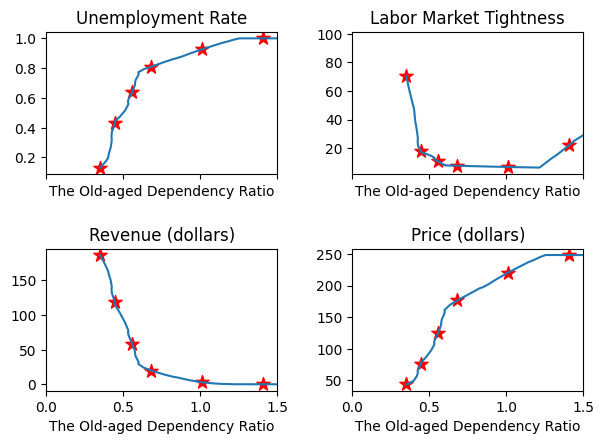

In [8]:
import random
import math
import sympy as sp
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

#initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05
initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.645, 0.147, 0.059

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_workforce * initial_aging_rate)

#job_finding_rate, job_separation_rate = 0.2, 0.2
job_finding_rate, job_separation_rate = 0.433, 0.024

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.9, 0.1, 0.01

# Initialize population
# not0_young_coh means persons with age from 1 to 14 inclusive
# young_coh means persons with age from 0 to 14 inclusive
newborn_coh, senior_coh, not0_young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed

    def update_age(self):
        self.age += 1

    def is_newborn(self):
        return self.age == 0

    def is_young(self):
        return self.age < 15

    def is_workforce(self):
        return 14 < self.age < retirement_age

    def is_senior(self):
        return self.age >= retirement_age

    def is_unemployed(self):
        return not self.employed

    def is_employed(self):
        return self.employed

# initialize population-related variables

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(1, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else not0_young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_coh = list(itertools.chain(newborn_coh, not0_young_coh))
pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))

cohorts = [[len(young_coh)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)

        if hire_or_fire_decision:  # Hiring decision
            #if update_job == 1:
            self.job_vacancy += num_new_vacancies
            #print(self.job_vacancy)
            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), num_new_vacancies)
            #self.job_vacancy -= num_hired

            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            self.job_vacancy -= int(0.01*self.job_vacancy)
            return 0, num_fired, self.job_vacancy


    def update_prices(self, total_demand):

        supply = len(emp_coh)
        #self.price = self.vacancy_cost + math.sqrt(total_demand) / len(firms) - supply / 2500
        self.price = self.vacancy_cost + total_demand / len(firms) - supply / 2500
        prof = max((self.price - self.vacancy_cost) * total_demand/len(firms),0)
        return self.price, prof

# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

def tt_demand(N, U, A, p_bar):
    B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
    S = N-U
    niu = min(1, S/B)

    return (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
    (N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
    U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/p_bar

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A

    def calculate_profit(self):
        p_bar0 = sum(firm.price for firm in self.firms)/len(firms)
        p_bar = sum(firm.update_prices(tt_demand(self.N, self.U, self.A, p_bar0))[0] for firm in self.firms)/len(self.firms)

        tot_demand = tt_demand(self.N, self.U, self.A, p_bar)
        tot_profit = sum(firm.update_prices(tot_demand)[1] for firm in self.firms)

        return tot_demand, tot_profit

'''
class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

'''
old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
random.seed(3)
num_firms = 1000
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]

# Initialize the LaborMarket with firms and initial_workforce
#labor_market = LaborMarket(firms)  # Pass initial_workforce here
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
#initial_vacancy = labor_market.new_workstatus()[2]
initial_vacancy = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
theta = [initial_vacancy / len(unemp_coh)]
initial_average_price = sum(firm.price for firm in firms) / len(firms)
prices_in_goods_market = [initial_average_price]

goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
tot_dem = [goods_market.calculate_profit()[0]]
job_vacancies = [initial_vacancy]

num_unemp = [len(unemp_coh)]

firm_profits = [goods_market.calculate_profit()[1]]

simulation_years = 300
random.seed(3)

for year in range(1, simulation_years):
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person

    for person in young_coh:
        person.update_age()
        if person.age == 1:
            updated_young_coh.append(person)
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)
# unit test
# manual test
# assert
    for person in workforce_coh:
        person.update_age()
        if person.is_workforce():
            updated_workforce_coh.append(person)
            if person.is_unemployed():
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)

    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)

    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(updated_senior_coh) * death_rate)
    random.shuffle(updated_senior_coh)
    removed_senior_coh = updated_senior_coh[:death]
    senior_coh = updated_senior_coh[death:]

    # Update the newborn
    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_young_coh.append(person)
        updated_newborn_coh.append(person)

    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = updated_workforce_coh
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh

    pop = list(itertools.chain(newborn_coh, young_coh, workforce_coh, senior_coh))
    #print('workforce proportion:', len(workforce_coh)/len(pop))
    #print('aged dependency ratio:', len(senior_coh)/len(workforce_coh))

    # firms updated
    """"for firm in firms:
      print(firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[0],firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[1], \
            firm.hire_or_fire(len(workforce_coh),len(unemp_coh))[2])
    """

    # Goods market dynamics
    goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
    total_demand_this_year = goods_market.calculate_profit()[0]

    #print('total_demand:', total_demand_this_year)
    tot_dem.append(total_demand_this_year)

    # Calculate new employment and unemployment rates for this year
    new_unemployment_rate = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    num_unemp.append(len(unemp_coh))
    unemployment_rates.append(new_unemployment_rate)

    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = len(pop)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate firm-related variables
    # num_job_vacancies = labor_market.new_workstatus()[2]
    num_job_vacancies = sum(firm.hire_or_fire(len(unemp_coh),len(emp_coh))[2] for firm in firms)
    job_vacancies.append(num_job_vacancies)
    #job_vacancies.append(num_job_vacancies)

    tot_price = 0
    for firm in firms:
        tot_price += firm.update_prices(total_demand_this_year)[0]

    #total_firm_profits = goods_market.calculate_profit()[1]
    total_firm_profits = sum(firm.update_prices(len(emp_coh))[1] for firm in firms)

    #supply_this_year = labor_market.new_workstatus()[0]
    supply_this_year = len(emp_coh)
    #print(supply_this_year, total_demand_this_year)
    #print('\n')

    #print('average price:', tot_price/len(firms))
    #print('total_firm_profits:', total_firm_profits)
    #print('\n')
    firm_profits.append(total_firm_profits)

    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)

    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    #total_prices_in_goods_market = sum(firm.update_prices(total_demand_this_year)[0] for firm in firms) / len(firms)
    total_prices_in_goods_market = tot_price
    prices_in_goods_market.append(total_prices_in_goods_market)
#print(tot_dem)

#store generated data to hard drive
data_1000 = [unemployment_rates, theta, firm_profits,prices_in_goods_market]

import csv

file_path = r"C:\Users\enmao\OneDrive-CU\mas thesis\code\simulation_data_1000.csv"

# Transpose the data (swap rows and columns)
transposed_data = zip(*data_1000)

# Open the file in write mode
with open(file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional)
    csv_writer.writerow(['Unemployment Rates', 'Theta', 'Firm Profits', 'Prices in Goods Market'])

    # Write the data to the CSV file
    csv_writer.writerows(transposed_data)
print("Simulation data saved to:", file_path)

# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
index= 4
axs[0, 0].plot(old_aged_dependency_ratios[index:], unemployment_rates[index:], label="Unemployment Rate")
axs[0, 0].scatter(old_aged_dependency_ratios[index::10], unemployment_rates[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 0].set_title('Unemployment Rate')

axs[0, 1].plot(old_aged_dependency_ratios[index:], theta[index:], label="Labor Market Tightness")
axs[0, 1].scatter(old_aged_dependency_ratios[index::10], theta[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[0, 1].set_title('Labor Market Tightness')

axs[1, 0].plot(old_aged_dependency_ratios[index:], firm_profits[index:], label="Revenue (dollars)")
axs[1, 0].scatter(old_aged_dependency_ratios[index::10], firm_profits[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 0].set_title('Revenue (dollars)')
#axs[1, 0].set_ylim(1.1, 1.3)

axs[1, 1].plot(old_aged_dependency_ratios[index:], prices_in_goods_market[index:], label="Prices in Goods Market")
axs[1, 1].scatter(old_aged_dependency_ratios[index::10], prices_in_goods_market[index::10], color='red', marker='*', s=100, label="Red Stars")
axs[1, 1].set_title('Price (dollars)')
#axs[1, 1].set_ylim(0, 0.38)

axs[0, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[0, 1].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 0].set_xlabel('The Old-aged Dependency Ratio')
axs[1, 1].set_xlabel('The Old-aged Dependency Ratio')

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
#fig.savefig(r'C:\Users\enmao\OneDrive - Carleton University\mas thesis\plot0926.png')
plt.show()


In [4]:
threshhold = 0.02
for i in range(len(old_aged_dependency_ratios)):
  if abs(old_aged_dependency_ratios[i]-1.5) < threshhold:
    zha = i
print(zha)


55


C:\Users\enmao\AppData\Local\Temp\ipykernel_8376\622552190.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(time, np.log10(firm_profits[index:]), label = "Log10 of Firms' Profit")
C:\Users\enmao\AppData\Local\Temp\ipykernel_8376\622552190.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot(time, np.log(prices_in_goods_market[index:]), label = "Natural Log of Prices in Good Market")


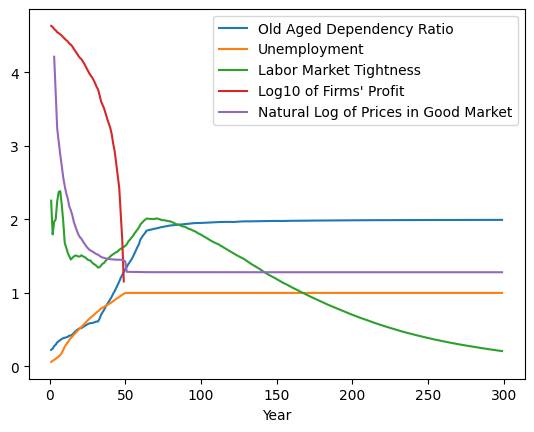

In [4]:
import numpy as np
index = 1
time = range(index, simulation_years)
plt.plot(time, old_aged_dependency_ratios[index:], label = "Old Aged Dependency Ratio")
plt.plot(time, unemployment_rates[index:], label = "Unemployment")
plt.plot(time, theta[index:], label = "Labor Market Tightness")
plt.plot(time, np.log10(firm_profits[index:]), label = "Log10 of Firms' Profit")
plt.plot(time, np.log(prices_in_goods_market[index:]), label = "Natural Log of Prices in Good Market")

plt.xlabel('Year')
plt.legend()
#fig.savefig(r'C:\Users\francischen\OneDrive - Carleton University\mas thesis\timeseries.png')
plt.show()

In [17]:
if 'plt.plot()' == 'plt.plot()':
  print("True")

else:
  print("False")

True


In [ ]:
plt.plot(time, unemployment_rates[index-3:], label=''Unemployment Rate'')
plt.plot(time, theta[index-3:], label=''Labor Market Tightness'')
plt.plot(time, firm_profits[index-3:], label=''Firms\' Profit'')
plt.plot(time, prices_in_goods_market[index-3:], label=''Prices in Good Market'')

In [ ]:
print(job_vacancies)
#print(firm_profits)
#print(prices_in_goods_market)
print(num_unemp)
print(theta)

[64, 97, 97, 120, 142, 182, 216, 248, 280, 313, 332, 365, 392, 418, 448, 484, 521, 552, 580, 608, 642, 682, 710, 740, 768, 793, 824, 859, 878, 902, 931, 957, 979, 1003, 1032, 1062, 1084, 1118, 1151, 1179, 1213, 1245, 1277, 1308, 1339, 1364, 1397, 1427, 1457, 1488, 1521, 1547, 1584, 1615, 1646, 1673, 1701, 1728, 1756, 1784, 1811, 1841, 1874, 1905, 1932, 1961, 1987, 2017, 2045, 2078, 2114, 2151, 2173, 2201, 2223, 2258, 2287, 2319, 2348, 2380, 2413, 2440, 2470, 2491, 2522, 2559, 2589, 2618, 2648, 2687, 2722, 2745, 2774, 2809, 2836, 2867, 2901, 2929, 2954, 2987, 3020, 3049, 3074, 3107, 3132, 3163, 3186, 3218, 3248, 3280, 3315, 3349, 3385, 3410, 3446, 3471, 3501, 3532, 3560, 3595, 3623, 3655, 3687, 3717, 3748, 3781, 3810, 3848, 3887, 3911, 3938, 3965, 3992, 4014, 4044, 4074, 4105, 4137, 4166, 4190, 4211, 4234, 4257, 4289, 4312, 4342, 4374, 4405, 4442, 4474, 4500, 4531, 4559, 4589, 4615, 4641, 4683, 4714, 4741, 4775, 4798, 4832, 4865, 4901, 4928, 4952, 4979, 5017, 5050, 5074, 5105, 5134, 516

In [ ]:
price = 125
ma_cap = 10402
earning = 78.388
